In [1]:
#Downloads market data from Yahoo! Finance's API
#https://pypi.org/project/yfinance/
import yfinance as yf

In [2]:
#creates instance of ticker class for s&p500
sp500 = yf.Ticker("^GSPC")

In [3]:
#get max historical market data for sp500
sp500 = sp500.history(period="max")

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,0.0,0.0
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,0.0,0.0
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000,0.0,0.0


In [5]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-04-29 00:00:00-04:00', '2024-04-30 00:00:00-04:00',
               '2024-05-01 00:00:00-04:00', '2024-05-02 00:00:00-04:00',
               '2024-05-03 00:00:00-04:00', '2024-05-06 00:00:00-04:00',
               '2024-05-07 00:00:00-04:00', '2024-05-08 00:00:00-04:00',
               '2024-05-09 00:00:00-04:00', '2024-05-10 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24206, freq=None)

<Axes: xlabel='Date'>

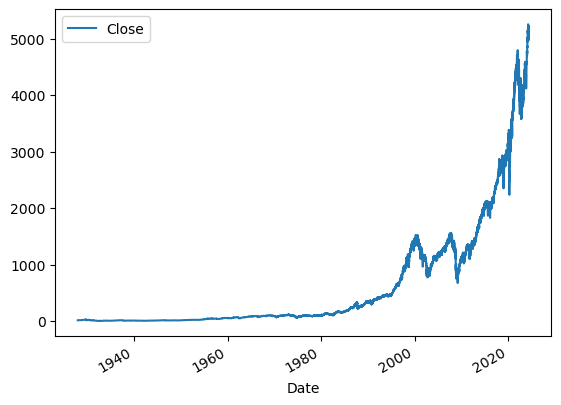

In [6]:
sp500.plot.line(y="Close",use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
#creates tmr column and makes info in it equal to price of next day's close
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,5187.700195
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,5187.669922
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000,5214.080078


In [10]:
#creates target column, assigns it to boolean of tmr > close, converts that boolean into an int
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [11]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,5187.700195,1
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,5187.669922,0
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000,5214.080078,1


In [12]:
#creates more up to date copy of stock market data since sp500 is old lol
sp500 = sp500.loc["1990-01-01":].copy()

#delete later... added to match date of video source
#sp500 = sp500.loc[:"2022-05-18"].copy()

In [13]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,5187.700195,1
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,5187.669922,0
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000,5214.080078,1


In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

#predictors = ["Close", "Volume", "Open", "High", "Low"]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [15]:
#used to measure how accurate predictions are
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [17]:
preds

Date
2023-12-18 00:00:00-05:00    0
2023-12-19 00:00:00-05:00    0
2023-12-20 00:00:00-05:00    0
2023-12-21 00:00:00-05:00    0
2023-12-22 00:00:00-05:00    0
                            ..
2024-05-06 00:00:00-04:00    0
2024-05-07 00:00:00-04:00    0
2024-05-08 00:00:00-04:00    0
2024-05-09 00:00:00-04:00    0
2024-05-10 00:00:00-04:00    0
Length: 100, dtype: int32

In [18]:
precision_score(test["Target"], preds)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [19]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

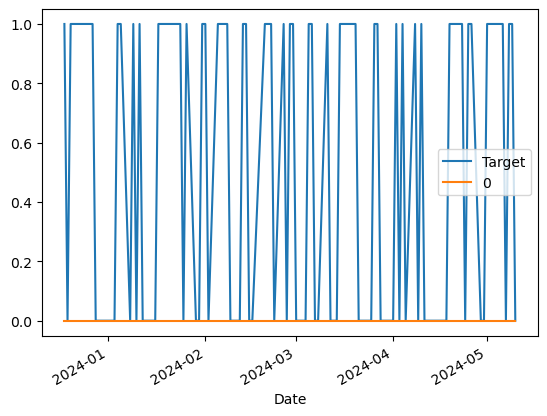

In [20]:
combined.plot()

In [21]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds,index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [22]:
#each market year is around 250 days (excluding weekends and holidays)
#we are testing on 10 years of data
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [23]:
predictions = backtest(sp500, model, predictors)

In [24]:
predictions["Predictions"].value_counts()

Predictions
0    3560
1    2596
Name: count, dtype: int64

In [25]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [26]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.5346
0    0.4654
Name: count, dtype: float64

In [27]:
#rolling averages
#close price across 2 days, week, 3 months, year, 4 years
horizons = [2,5,60,250,1000]

new_predictors = []
for horizon in horizons:

    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column= f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [28]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,5187.700195,1,1.005137,2.0,1.018755,3.0,1.013309,30.0,1.119127,138.0,1.247787,531.0
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,5187.669922,0,1.000671,2.0,1.014062,4.0,1.014137,30.0,1.119596,139.0,1.248765,531.0
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000,5214.080078,1,0.999997,1.0,1.007389,4.0,1.013584,30.0,1.118576,138.0,1.248086,530.0


In [29]:
#drops rows with Na values
sp500 = sp500.dropna()

In [30]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03 00:00:00-04:00,5122.779785,5139.120117,5101.220215,5127.790039,3924990000,5180.740234,1,1.006239,2.0,1.010910,3.0,1.003550,30.0,1.108687,138.0,1.235727,531.0
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,5187.700195,1,1.005137,2.0,1.018755,3.0,1.013309,30.0,1.119127,138.0,1.247787,531.0
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,5187.669922,0,1.000671,2.0,1.014062,4.0,1.014137,30.0,1.119596,139.0,1.248765,531.0


In [31]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [32]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    #returns 1 when probability is above.5 by default but we prefer .6 for greater certainty
    #reduced trading days number but increases quality 
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds,index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [33]:
predictions = backtest(sp500, model, new_predictors)

In [34]:
predictions["Predictions"].value_counts()

Predictions
0.0    4320
1.0     835
Name: count, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5736526946107784